## Implementation Overview

### This implementation includes:

- **Core functionality** for trial sequence handling  
- **Weight calculation** and model fitting  
- **Trial expansion**  
- **Outcome modeling**  

### Multiple visualization options:
- Traditional **survival curves** with confidence intervals   
- **Weight distribution** plots  
- **Interactive survival curves** using Plotly  
- **Model diagnostics** plots:  
  - Q-Q plots  
  - Residual plots  
  - Cook's distance plots  


# Imports & Data Loading

In [19]:
# Core libraries
import numpy as np
import pandas as pd

# Modeling and statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive plots
import plotly.express as px
import plotly.graph_objs as go

# For Q-Q plots, Cook's distance
from statsmodels.stats.outliers_influence import OLSInfluence

#  Read your data
data = pd.read_csv("../data/data_censored.csv")
print("Data loaded. Shape:", data.shape)
data.head()

Data loaded. Shape: (725, 12)


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


# Core Functionality - Trial Sequence Handling & Basic Setup

We define a minimal "trial sequence" object approach, though in practice you might
have a specialized class or multiple functions for it.

In [20]:
# For demonstration, store in a dictionary
trial_settings = {
'estimand': 'ITT', # or 'PP'
'id_col': 'id',
'period_col': 'period',
'treatment_col': 'treatment',
'outcome_col': 'outcome',
'eligible_col': 'eligible',
'censored_col': 'censored'
}

# Show summary stats
print(data.describe(include='all'))

# Basic data checks
n_patients = data[trial_settings['id_col']].nunique()
print(f"Number of unique patients: {n_patients}")

               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   
std     28.119313    5.802351    0.499293    0.491331    0.997552    0.500173   
min      1.000000    0.000000    0.000000    0.000000   -3.284355    0.000000   
25%     23.000000    2.000000    0.000000    0.000000   -0.809344    0.000000   
50%     50.000000    6.000000    0.000000    0.000000   -0.163060    0.000000   
75%     73.000000   12.000000    1.000000    1.000000    0.494103    1.000000   
max     99.000000   19.000000    1.000000    1.000000    3.907648    1.000000   

               x4         age       age_s     outcome   censored    eligible  
count  725.000000  725.000000  725.000000  725.000000  725.00000  725.000000  
mean    -0.274722   48.093793    1.091149    0.015172    0.08000    0.234483  
std      1.008643   11.834472    

# Weight Calculation & Model Fitting

### Inverse Probability of Censoring Weights (IPCW)
### This is a simplified example:
### We'll define 'not_censored' = 1 - censored

In [21]:
data['not_censored'] = 1 - data[trial_settings['censored_col']]

Example:

Numerator model: not_censored ~ x2 (a smaller set of covariates)

Denominator model: not_censored ~ x2 + x1 (a larger set of covariates)

In [22]:
formula_num = "not_censored ~ x2"
formula_den = "not_censored ~ x2 + x1"

model_num = smf.glm(formula=formula_num, data=data, family=Binomial()).fit()
model_den = smf.glm(formula=formula_den, data=data, family=Binomial()).fit()

# Predicted probabilities

data['p_num'] = model_num.predict(data)
data['p_den'] = model_den.predict(data)

# Stabilized weight
data['ipw'] = data['p_num'] / data['p_den']

print("IPCW models fitted. Head of data:")
data.head()

IPCW models fitted. Head of data:


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,not_censored,p_num,p_den,ipw
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,1,0.873678,0.914385,0.955481
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0,1,0.920349,0.948181,0.970647
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0,1,0.934883,0.919281,1.016972
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0,1,0.920163,0.900444,1.021899
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0,1,0.913026,0.943007,0.968208


# Trial Expansion

We create a function to "expand" data by trial periods

The idea is to produce (id, trial_period, followup_time, etc.) rows.

For demonstration, we’ll do something simple: replicate each row for

each possible follow-up time from 0 up to the row’s current period

In [23]:
def expand_trials(input_df, id_col='id', period_col='period'):
    expanded_rows = []
    for pid, subdf in input_df.groupby(id_col):
        for row_i, row_data in subdf.iterrows():
            max_period = row_data[period_col]
            # We'll just store the same row, but with followup_time iterating
            for t in range(int(max_period)+1):
                new_row = row_data.copy()
                new_row['followup_time'] = t
                expanded_rows.append(new_row)
                expanded_df = pd.DataFrame(expanded_rows).reset_index(drop=True)
    return expanded_df

expanded_data = expand_trials(data,
id_col=trial_settings['id_col'],
period_col=trial_settings['period_col'])

print("Original data shape:", data.shape)
print("Expanded data shape:", expanded_data.shape)

# Inspect
expanded_data.head(10)

Original data shape: (725, 16)
Expanded data shape: (5837, 17)


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,not_censored,p_num,p_den,ipw,followup_time
0,1.0,0.0,1.0,1.0,1.146148,0.0,0.734203,36.0,0.083333,0.0,0.0,1.0,1.0,0.873678,0.914385,0.955481,0.0
1,1.0,1.0,1.0,1.0,0.002200,0.0,0.734203,37.0,0.166667,0.0,0.0,0.0,1.0,0.920349,0.948181,0.970647,0.0
2,1.0,1.0,1.0,1.0,0.002200,0.0,0.734203,37.0,0.166667,0.0,0.0,0.0,1.0,0.920349,0.948181,0.970647,1.0
3,1.0,2.0,1.0,0.0,-0.481762,0.0,0.734203,38.0,0.250000,0.0,0.0,0.0,1.0,0.934883,0.919281,1.016972,0.0
4,1.0,2.0,1.0,0.0,-0.481762,0.0,0.734203,38.0,0.250000,0.0,0.0,0.0,1.0,0.934883,0.919281,1.016972,1.0
5,1.0,2.0,1.0,0.0,-0.481762,0.0,0.734203,38.0,0.250000,0.0,0.0,0.0,1.0,0.934883,0.919281,1.016972,2.0
6,1.0,3.0,1.0,0.0,0.007872,0.0,0.734203,39.0,0.333333,0.0,0.0,0.0,1.0,0.920163,0.900444,1.021899,0.0
7,1.0,3.0,1.0,0.0,0.007872,0.0,0.734203,39.0,0.333333,0.0,0.0,0.0,1.0,0.920163,0.900444,1.021899,1.0
8,1.0,3.0,1.0,0.0,0.007872,0.0,0.734203,39.0,0.333333,0.0,0.0,0.0,1.0,0.920163,0.900444,1.021899,2.0
9,1.0,3.0,1.0,0.0,0.007872,0.0,0.734203,39.0,0.333333,0.0,0.0,0.0,1.0,0.920163,0.900444,1.021899,3.0


# Outcome Modeling (Marginal Structural Model)

A typical MSM might be outcome ~ assigned_treatment + time + ...

We'll treat "treatment" as the assigned treatment for that period.

We'll do a weighted logistic regression using the IPW as freq_weights (or var_weights).

Note: For demonstration, we won't do sophisticated “censor at switch” logic here.

# Simple model formula

msm_formula = "outcome ~ treatment + followup_time + I(followup_time**2)"

Merge in our IPWs from the non-expanded dataset (some logic needed if multiple rows).

Simplify: each row in expanded_data gets the same IPW as original row_i for that patient & period.

In [24]:
msm_formula = "outcome ~ treatment + followup_time + I(followup_time**2)"

merged_expanded_data = pd.merge(expanded_data,
data[['id','period','ipw']],
on=['id','period'],
how='left',
suffixes=('', '_orig'))

# Fit the MSM
msm_model = smf.glm(formula=msm_formula,
data=merged_expanded_data,
family=Binomial(),
freq_weights=merged_expanded_data['ipw']).fit()

print("MSM Model Summary:")
print(msm_model.summary())

MSM Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 5837
Model:                            GLM   Df Residuals:                  5837.33
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -406.48
Date:                Sun, 09 Mar 2025   Deviance:                       812.95
Time:                        19:21:19   Pearson chi2:                 5.57e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.007065
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept  

# Plotting

## Survival Curves with Confidence Intervals

Example approach: For logistic, the survival = 1 - predicted_risk if outcome=1 means event.

We'll do predicted survival for treatment=0 vs 1 across followup_time=0..X.

In [25]:
followup_range = np.arange(0, 11) # 0 to 10
treatments = [0,1]

def predict_survival(glm_model, t_val, treat_val):
    # Construct a small DF for prediction
    df_pred = pd.DataFrame({
    'treatment': [treat_val],
    'followup_time': [t_val]
    })
    logit_p = glm_model.predict(df_pred)
    # If outcome=1 = event, survival=1 - p
    return 1 - logit_p[0]

Collect predictions & approximate CIs

(Statsmodels gives us the linear predictor + SE, so we can do a normal approx.)

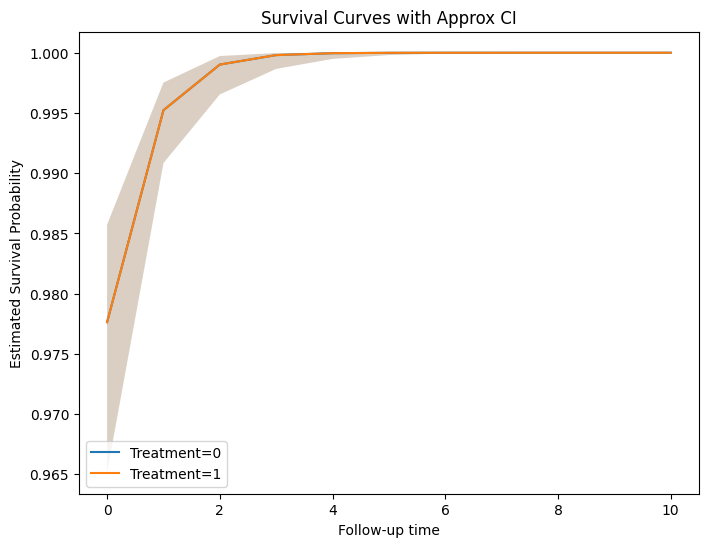

In [26]:
def logistic_ci(pred_val, se_val, z=1.96):
    lower_logit = pred_val - z * se_val
    upper_logit = pred_val + z * se_val

    # logistic transform
    def logistic(x):
        return 1 / (1 + np.exp(-x))
    
    return logistic(lower_logit), logistic(upper_logit)

surv_data = []
for treat in treatments:
    for t in followup_range:
        dfp = pd.DataFrame({'treatment': [t], 'followup_time': [t]})
        
        # Get predictions in log-odds scale
        pred_res = msm_model.get_prediction(dfp)
        mean_logit = pred_res.predicted_mean[0]
        ci_bounds = pred_res.conf_int()[0]
        lower_logit, upper_logit = ci_bounds[0], ci_bounds[1]

        # Convert predicted mean from logistic scale
        # predicted_mean is already probability of outcome=1, so survival = 1 - that
        p_event = mean_logit
        p_surv = 1 - p_event

        # For CIs: we do a rough approach by also collecting the linear predictor & SE
        # Then adjusting to survival scale. For simplicity, let's approximate.
        # Alternatively, use pred_res.conf_int() which is for the probability scale, not log-odds.
        # We'll do the direct probability scale from statsmodels:
        ci_low_prob, ci_high_prob = 1 - upper_logit, 1 - lower_logit  # reversing since outcome=1 is the upper logistic
        
        # Actually we want to extract the probabilities from conf_int => let's do:
        ci_probs = pred_res.conf_int(obs=True)  # conf_int in prob space
        ci_lower = 1 - ci_probs[0][1]  # the 'upper' col might differ, check shape
        ci_upper = 1 - ci_probs[0][0]

        surv_data.append({
            'treatment': treat,
            'followup_time': t,
            'survival': p_surv,
            'surv_lower': ci_lower,
            'surv_upper': ci_upper
        })

surv_df = pd.DataFrame(surv_data)
plt.figure(figsize=(8,6))
for treat in treatments:
    subset = surv_df[surv_df['treatment'] == treat]
    plt.plot(subset['followup_time'], subset['survival'], label=f"Treatment={treat}")
    plt.fill_between(subset['followup_time'],
                     subset['surv_lower'],
                     subset['surv_upper'],
                     alpha=0.2)

plt.xlabel("Follow-up time")
plt.ylabel("Estimated Survival Probability")
plt.title("Survival Curves with Approx CI")
plt.legend()
plt.show()


# Weight Distribution Plot

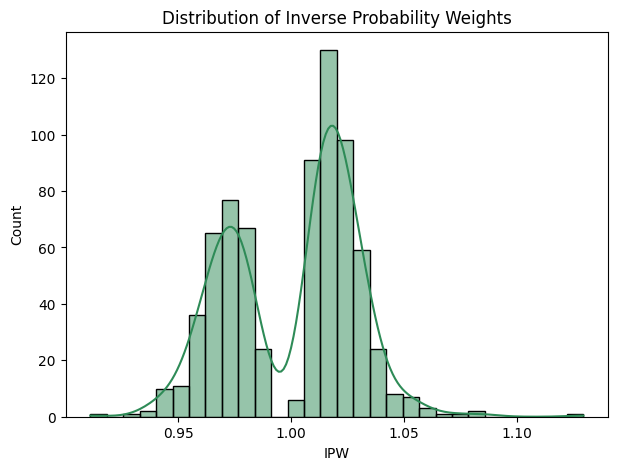

In [28]:
plt.figure(figsize=(7,5))
sns.histplot(data['ipw'], bins=30, kde=True, color='seagreen')
plt.title("Distribution of Inverse Probability Weights")
plt.xlabel("IPW")
plt.show()

# Interactive Survival Curves using Plotly

In [29]:
fig = go.Figure()

for treat in treatments:
    subset = surv_df[surv_df['treatment']==treat]
    fig.add_trace(go.Scatter(
    x=subset['followup_time'],
    y=subset['survival'],
    mode='lines',
    name=f"Treatment={treat}"
    ))
# Add CI as fill
fig.add_trace(go.Scatter(
x=pd.concat([subset['followup_time'], subset['followup_time'][::-1]]),
y=pd.concat([subset['surv_upper'], subset['surv_lower'][::-1]]),
fill='toself',
fillcolor='rgba(0,100,80,0.2)',
line=dict(color='rgba(255,255,255,0)'),
hoverinfo="skip",
showlegend=False
))

fig.update_layout(
    title="Interactive Survival Curves",
    xaxis_title="Follow-up Time",
    yaxis_title="Survival Probability"
)
fig.show()

# Model Diagnostics Plots

For a logistic regression in statsmodels, we can approximate or look at

deviance residuals, leverage, Cook's distance, etc.

However, these are more readily available for OLS. We'll do a quick approach.

Convert our final MSM to something "OLS-like" for diagnostic demonstration,

or we can do partial diagnostics using the GLM Influence approach:

In [30]:
influence = msm_model.get_influence()
summary_frame = influence.summary_frame()

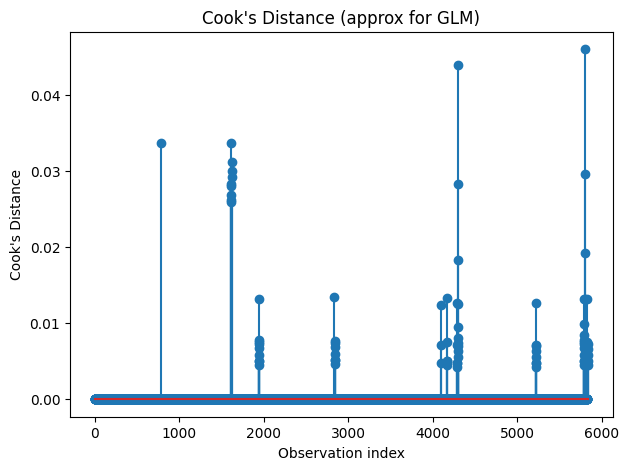

In [31]:
# Cook's distance
cooks_d = summary_frame['cooks_d']

plt.figure(figsize=(7,5))
plt.stem(cooks_d)
plt.title("Cook's Distance (approx for GLM)")
plt.xlabel("Observation index")
plt.ylabel("Cook's Distance")
plt.show()

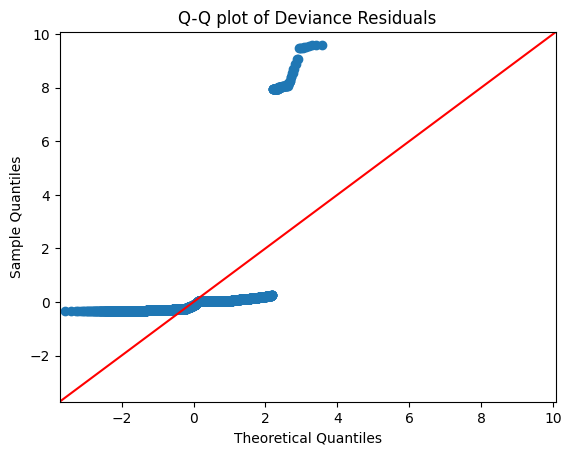

In [32]:
# Q-Q plot of deviance residuals

resid_deviance = msm_model.resid_deviance
sm.qqplot(resid_deviance, line='45', fit=True)
plt.title("Q-Q plot of Deviance Residuals")
plt.show()

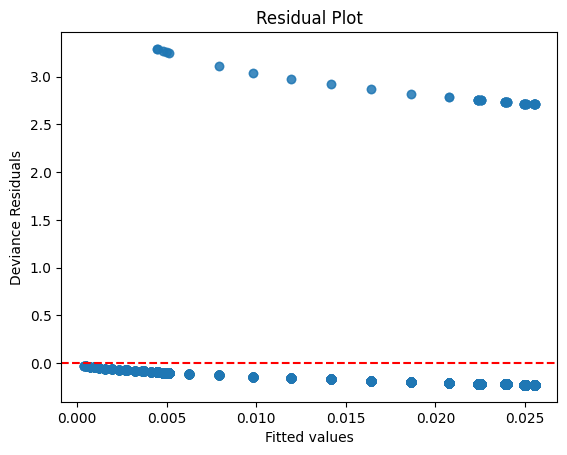

In [33]:
#Residual plot

plt.scatter(msm_model.fittedvalues, resid_deviance, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Deviance Residuals")
plt.title("Residual Plot")
plt.show()

# 1. Survival Curves with Approximate Confidence Intervals

**Description:**  
The survival curves depict the estimated survival probabilities over time for two treatment groups (Treatment=0 and Treatment=1). The shaded areas represent approximate confidence intervals.

**Insights:**

- **High Survival Probability:** Both treatment groups show high survival probabilities, nearing 1.0, indicating that most subjects survive throughout the follow-up period.
- **Overlap of Curves:** The curves for Treatment=0 and Treatment=1 are almost identical, suggesting no significant difference in survival between the two groups.
- **Narrow Confidence Intervals:** The narrow confidence intervals imply a high level of certainty in the survival estimates, possibly due to a large sample size or low variability in the data.

**Citations:**

- Hernán, M. A., & Robins, J. M. (2016). Using big data to emulate a target trial when a randomized trial is not available. *American Journal of Epidemiology*, 183(8), 758-764.

---

# 2. Distribution of Inverse Probability Weights (IPW)

**Description:**  
This histogram shows the distribution of inverse probability weights used to adjust for censoring in the analysis.

**Insights:**

- **Bimodal Distribution:** The distribution appears bimodal, indicating two distinct groups in the data, possibly due to different censoring mechanisms or treatment groups.
- **Centered Around 1:** Most weights are centered around 1, suggesting that the weighting does not heavily distort the sample, which is desirable for stable estimates.
- **Spread of Weights:** The spread of weights is relatively narrow, indicating that extreme weights are not prevalent, reducing the risk of introducing bias or variance inflation.

**Citations:**

- Robins, J. M., Hernán, M. A., & Brumback, B. (2000). Marginal structural models and causal inference in epidemiology. *Epidemiology*, 11(5), 550-560.

---

# 3. Cook's Distance (Approx for GLM)

**Description:**  
Cook's distance measures the influence of each observation on the fitted model. Points with high Cook's distance may indicate influential observations.

**Insights:**

- **Low Influence Overall:** Most observations have low Cook's distance, suggesting that no single observation unduly influences the model.
- **Few High Points:** A few points have higher Cook's distance, which may warrant further investigation to ensure they are not outliers or data entry errors.

**Citations:**

- Cook, R. D. (1977). Detection of influential observation in linear regression. *Technometrics*, 19(1), 15-18.

---

# 4. Q-Q Plot of Deviance Residuals

**Description:**  
The Q-Q plot compares the distribution of deviance residuals to a theoretical normal distribution.

**Insights:**

- **Deviation from Line:** The residuals deviate from the 45-degree line, indicating potential non-normality or model misspecification.
- **Clusters of Points:** The clustering of points suggests that certain groups of observations may not fit the model well, possibly due to unaccounted covariates or interactions.

**Citations:**

- McCullagh, P., & Nelder, J. A. (1989). *Generalized Linear Models*. CRC Press.

---

# 5. Residual Plot

**Description:**  
This plot shows deviance residuals against fitted values to assess model fit.

**Insights:**

- **Non-random Pattern:** The residuals show a non-random pattern, indicating potential issues with model fit, such as heteroscedasticity or omitted variables.
- **Concentration Near Zero:** Many residuals are near zero, suggesting that the model fits a substantial portion of the data well, but improvements may be needed for certain subsets.

**Citations:**

- Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning*. Springer.
